In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt  # Graphics
from matplotlib import colors
import seaborn  # Graphics
import geopandas  # Spatial data manipulation
import pandas  # Tabular data manipulation
import rioxarray  # Surface data manipulation
import xarray  # Surface data manipulation
from pysal.explore import esda  # Exploratory Spatial analytics
from pysal.lib import weights  # Spatial weights
import contextily  # Background tiles
import warnings
warnings.filterwarnings("ignore")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/sukantodas/anaconda3/envs/pubdis/lib/python3.10/site-packages/spaghetti/network.py:40: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [2]:
url = url = 'https://raw.github.com/ssujit/move_sustainable/main/data/'

# variable declaration
wkam = 'wk_am_hamburg.gpkg' # wk_am: weekdays peak-traffic morning hours (6:00-8:59) 

#read the files
wk_am = gpd.read_file(f'{url}{wkam}')

In [3]:
wk_am.head()

,VALUE,grid_name,net_dis,perH_sum,fi,geometry
0,514.24882,6,514,1.665,0.003,"POLYGON ((574591.689 5952249.123, 575602.193 5..."
1,954.49117,9,954,5.665,0.006,"POLYGON ((570549.674 5951247.039, 571560.177 5..."
2,167.29258,11,167,46.000,0.275,"POLYGON ((572570.681 5951247.039, 573581.185 5..."
3,517.34294,12,517,11.670,0.023,"POLYGON ((573581.185 5951247.039, 574591.689 5..."
4,745.92077,13,746,0.665,0.001,"POLYGON ((574591.689 5951247.039, 575602.193 5..."


In [4]:
wk_am.explore()

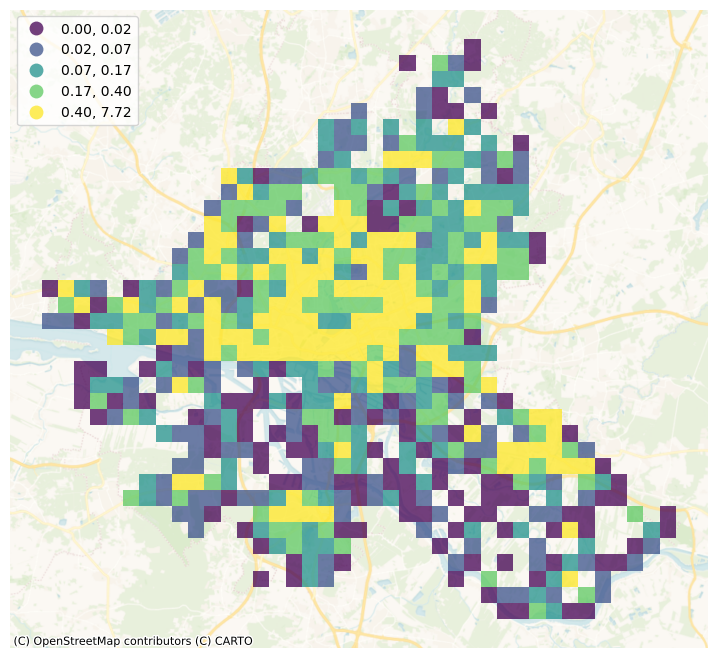

In [5]:
# Set up figure and a single axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Build choropleth
wk_am.plot(
    column="fi",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax,
)
# Add basemap
contextily.add_basemap(
    ax,
    crs=wk_am.crs,
    source=contextily.providers.CartoDB.VoyagerNoLabels,
)
# Remove axes
ax.set_axis_off();

In [6]:
# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(wk_am, k=8)
# Row-standardization
w.transform = "R"

In [7]:
wk_am["w_fi"] = weights.lag_spatial(w, wk_am['fi'])

In [8]:
wk_am["fi_std"] = wk_am["fi"] - wk_am["fi"].mean()
wk_am["w_fi_std"] = weights.lag_spatial(w, wk_am['fi_std'])

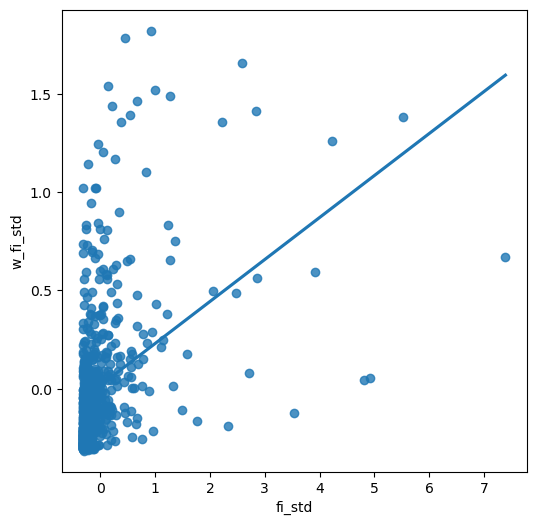

In [9]:
# Set up the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(
    x="fi_std", y="w_fi_std", data=wk_am, ci=None
)
plt.show()

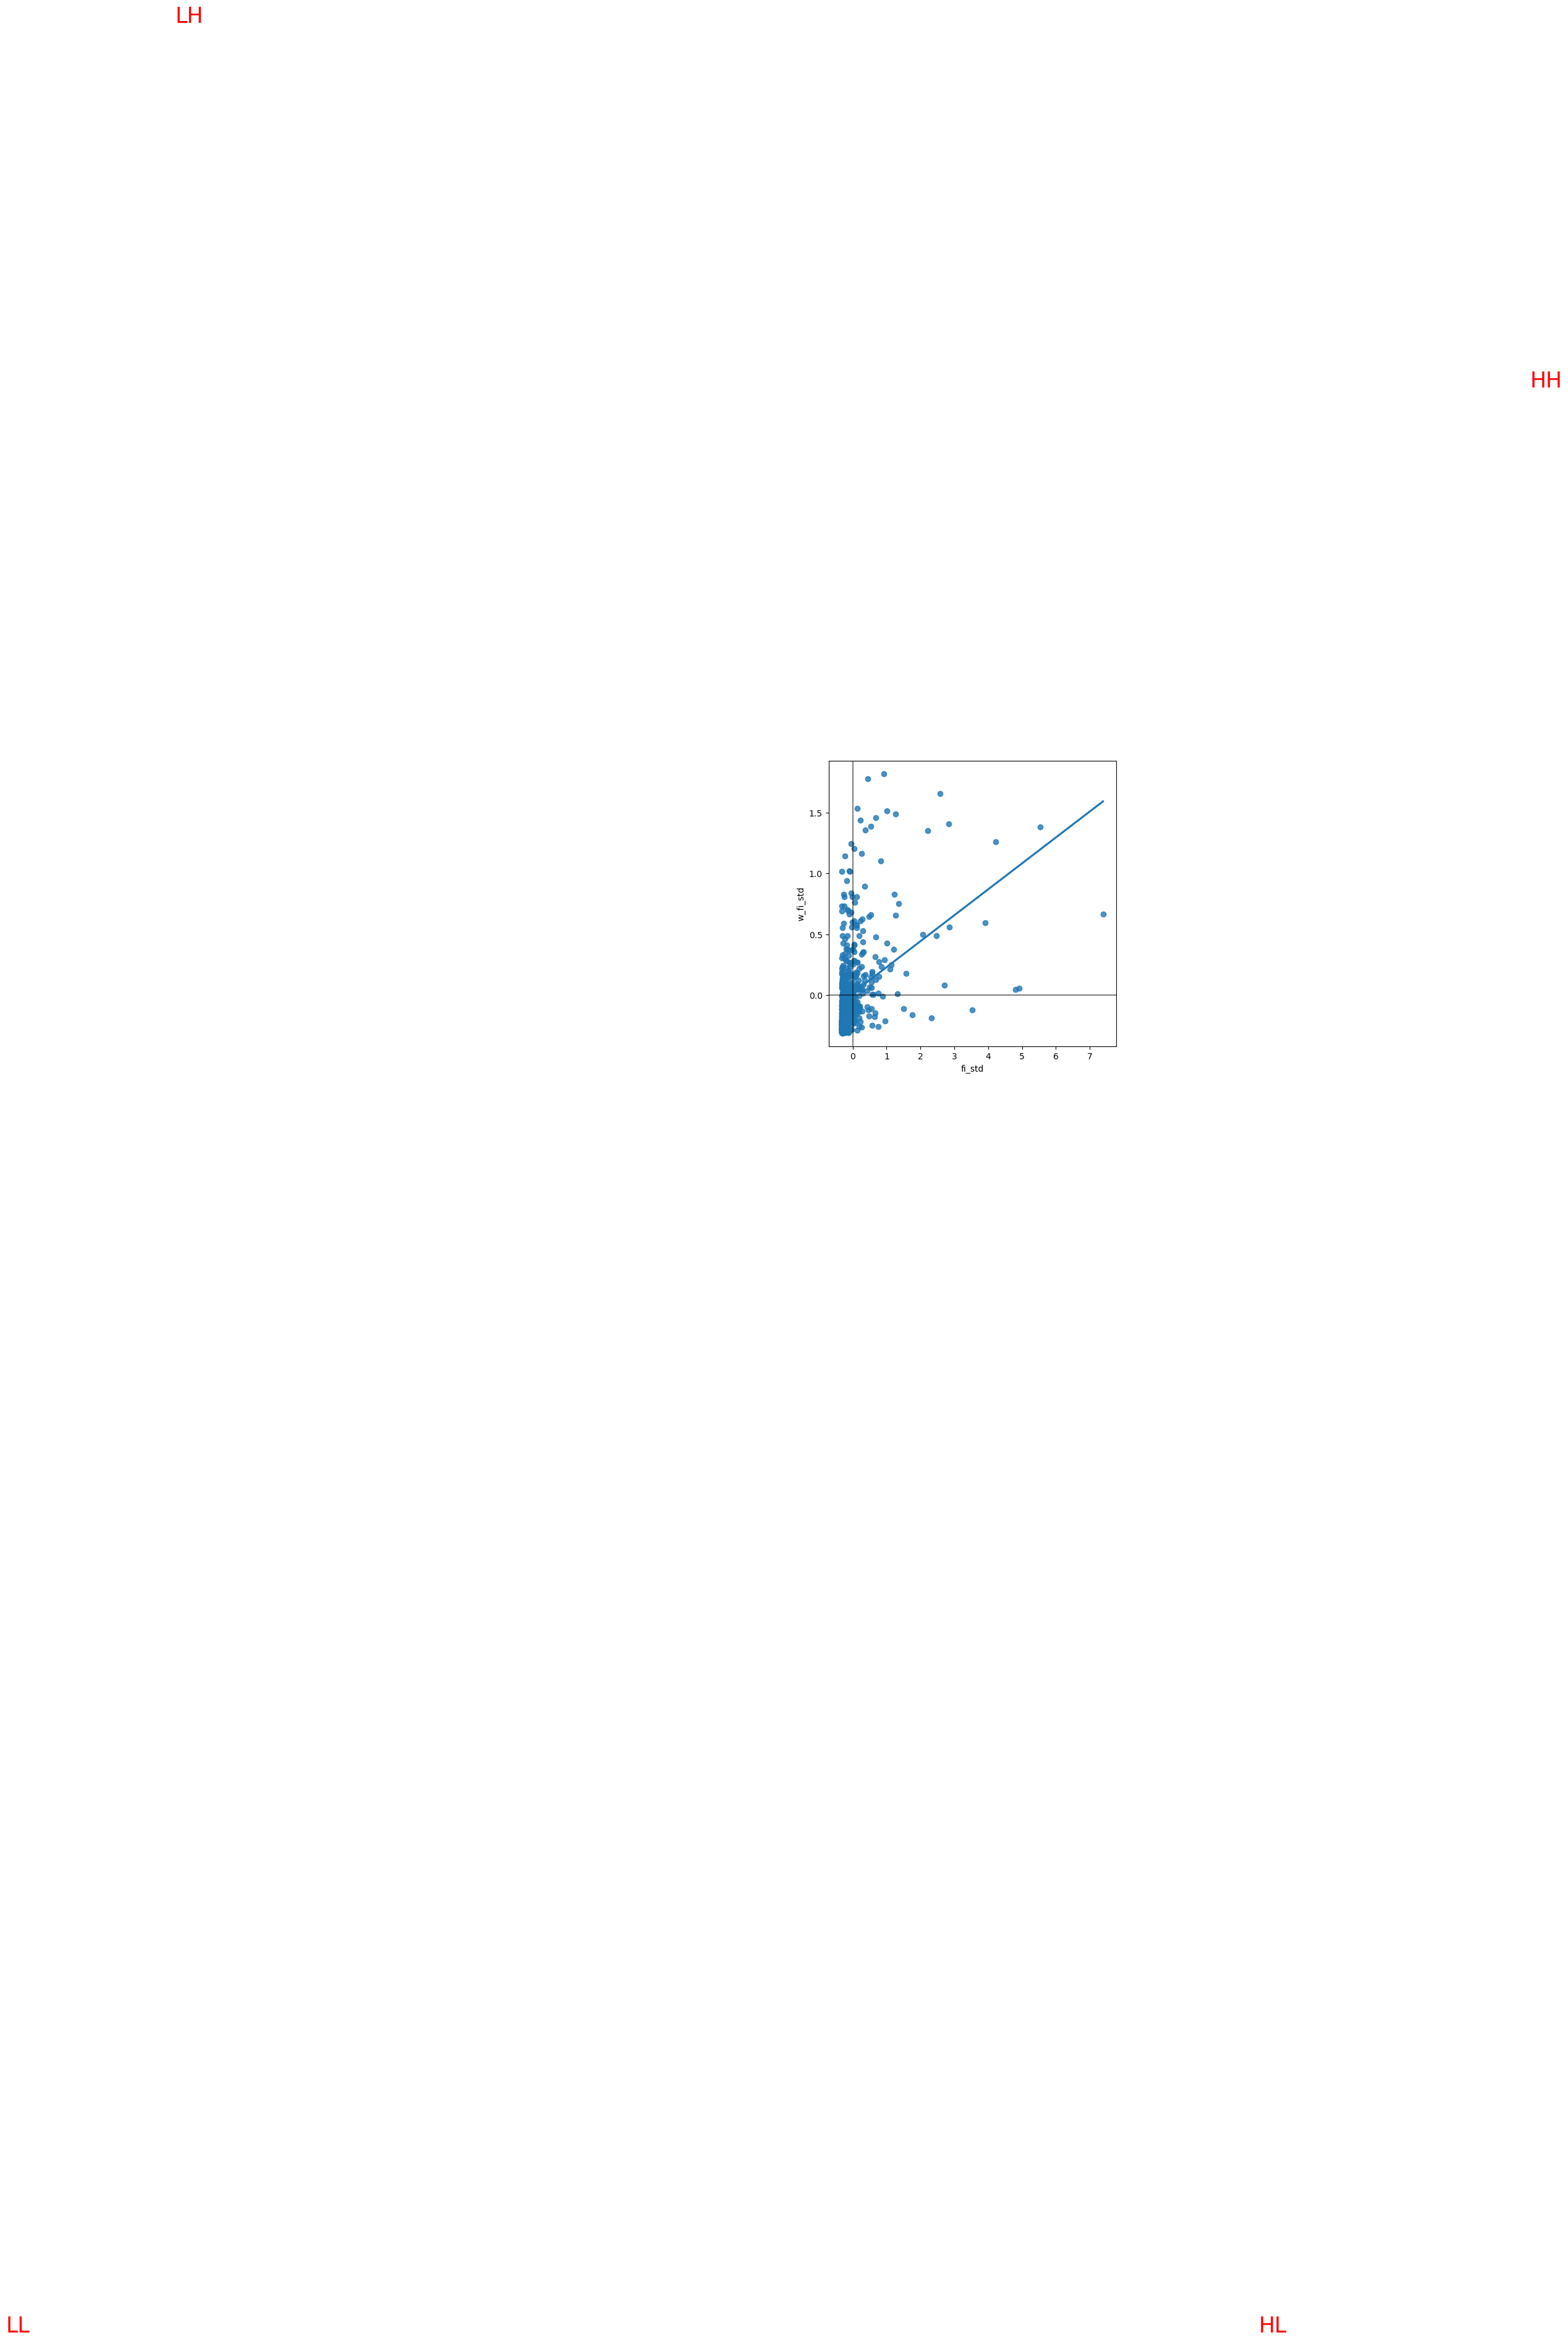

In [10]:
# Set up the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(
    x="fi_std", y="w_fi_std", data=wk_am, ci=None
)
# Add vertical and horizontal lines
plt.axvline(0, c="k", alpha=0.5)
plt.axhline(0, c="k", alpha=0.5)
# Add text labels for each quadrant
plt.text(20, 5, "HH", fontsize=25, c="r")
plt.text(12, -11, "HL", fontsize=25, c="r")
plt.text(-20, 8.0, "LH", fontsize=25, c="r")
plt.text(-25, -11.0, "LL", fontsize=25, c="r")
# Display
plt.show()

In [11]:
lisa = esda.moran.Moran_Local(wk_am["fi"], w)

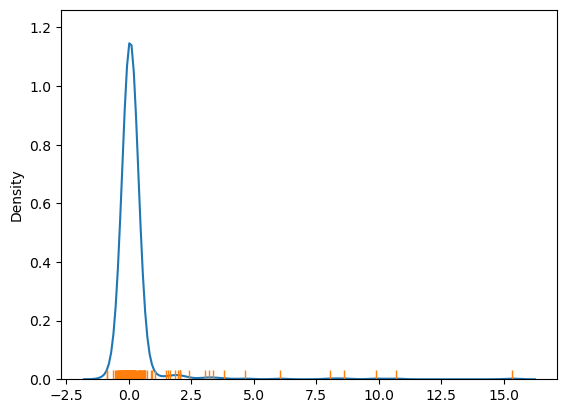

In [12]:
# Draw KDE line
ax = seaborn.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
seaborn.rugplot(lisa.Is, ax=ax);

In [13]:
from splot import esda as esdaplot

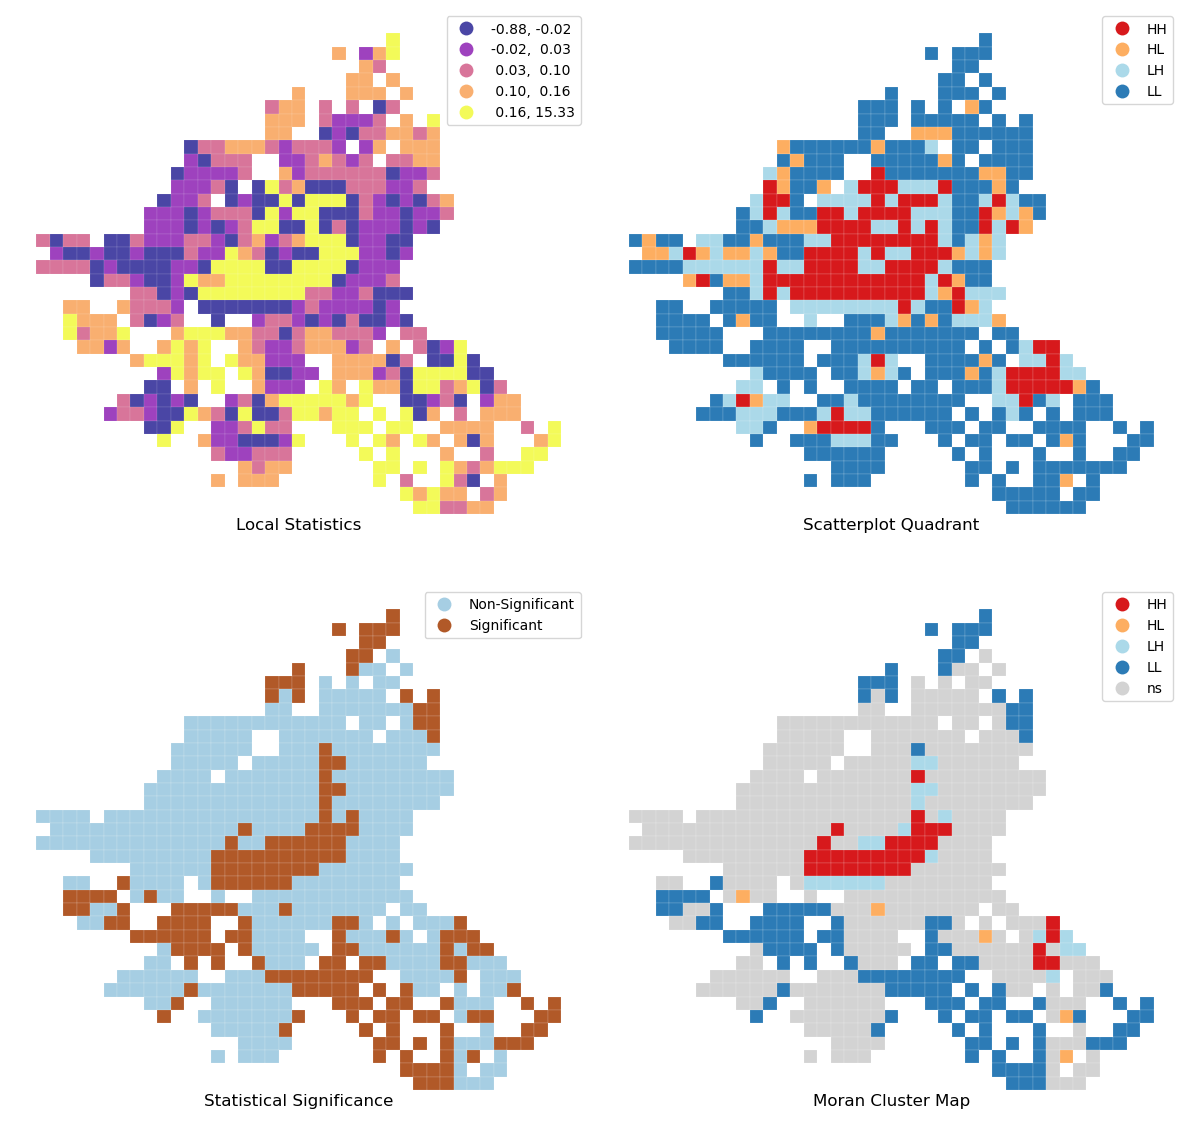

In [14]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
wk_am.assign(
    Is=lisa.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quadrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, wk_am, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pandas.Series(
    1 * (lisa.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=wk_am.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
wk_am.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)


# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quadrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, wk_am, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimize in-between white space
f.tight_layout()

# Display the figure
plt.show()

In [15]:
counts = pandas.value_counts(lisa.q)
counts

3    334
2    111
1    103
4     50
Name: count, dtype: int64

In [16]:
(lisa.p_sim < 0.05).sum() * 100 / len(lisa.p_sim)

31.270903010033443

In [17]:
# Assign pseudo P-values to `db`
wk_am["p-sim"] = lisa.p_sim
# `1` if significant (at 5% confidence level), `0` otherwise
sig = 1 * (lisa.p_sim < 0.05)
# Assign significance flag to `db`
wk_am["sig"] = sig
# Print top of the table to inspect
wk_am[["sig", "p-sim"]].head()

,sig,p-sim
0,1,0.032
1,1,0.040
2,1,0.005
3,1,0.034
4,1,0.034


In [18]:
# Print bottom of the table to inspect
wk_am[["sig", "p-sim"]].tail()

,sig,p-sim
593,1,0.024
594,1,0.007
595,0,0.176
596,0,0.257
597,0,0.196


In [19]:
# Pick as part of a quadrant only significant polygons,
# assign `0` otherwise (Non-significant polygons)
spots = lisa.q * sig
# Mapping from value to name (as a dict)
spots_labels = {
    0: "Non-Significant",
    1: "HH",
    2: "LH",
    3: "LL",
    4: "HL",
}
# Create column in `db` with labels for each polygon
wk_am["labels"] = pandas.Series(
    # First initialise a Series using values and `db` index
    spots,
    index=wk_am.index
    # Then map each value to corresponding label based
    # on the `spots_labels` mapping
).map(spots_labels)
# Print top for inspection
wk_am["labels"].head()

0    LL
1    LL
2    LL
3    LL
4    LL
Name: labels, dtype: object

In [20]:
wk_am["labels"].value_counts()

labels
Non-Significant    411
LL                 128
HH                  33
LH                  21
HL                   5
Name: count, dtype: int64

In [21]:
# Gi
go_i = esda.getisord.G_Local(wk_am["fi"], w)
# Gi*
go_i_star = esda.getisord.G_Local(wk_am["fi"], w, star=True)

In [22]:
def g_map(g, wk_am, ax):
    """
    Create a cluster map
    ...

    Arguments
    ---------
    g      : G_Local
             Object from the computation of the G statistic
    wk_am     : GeoDataFrame
             Table aligned with values in `g` and containing
             the geometries to plot
    ax     : AxesSubplot
             `matplotlib` axis to draw the map on

    Returns
    -------
    ax     : AxesSubplot
             Axis with the map drawn
    """
    ec = "0.8"

    # Break observations into significant or not
    sig = g.p_sim < 0.05

    # Plot non-significant clusters
    ns = wk_am.loc[sig == False, "geometry"]
    ns.plot(ax=ax, color="lightgrey", edgecolor=ec, linewidth=0.1)
    # Plot HH clusters
    hh = wk_am.loc[(g.Zs > 0) & (sig == True), "geometry"]
    hh.plot(ax=ax, color="red", edgecolor=ec, linewidth=0.1)
    # Plot LL clusters
    ll = wk_am.loc[(g.Zs < 0) & (sig == True), "geometry"]
    ll.plot(ax=ax, color="blue", edgecolor=ec, linewidth=0.1)
    # Style and draw
    contextily.add_basemap(
        ax,
        crs=wk_am.crs,
        source=contextily.providers.CartoDB.VoyagerNoLabels,
    )
    # Flag to add a star to the title if it's G_i*
    st = ""
    if g.star:
        st = "*"
    # Add title
    ax.set_title(f"G{st} statistic for Pct of Leave votes", size=15)
    # Remove axis for aesthetics
    ax.set_axis_off()
    return ax

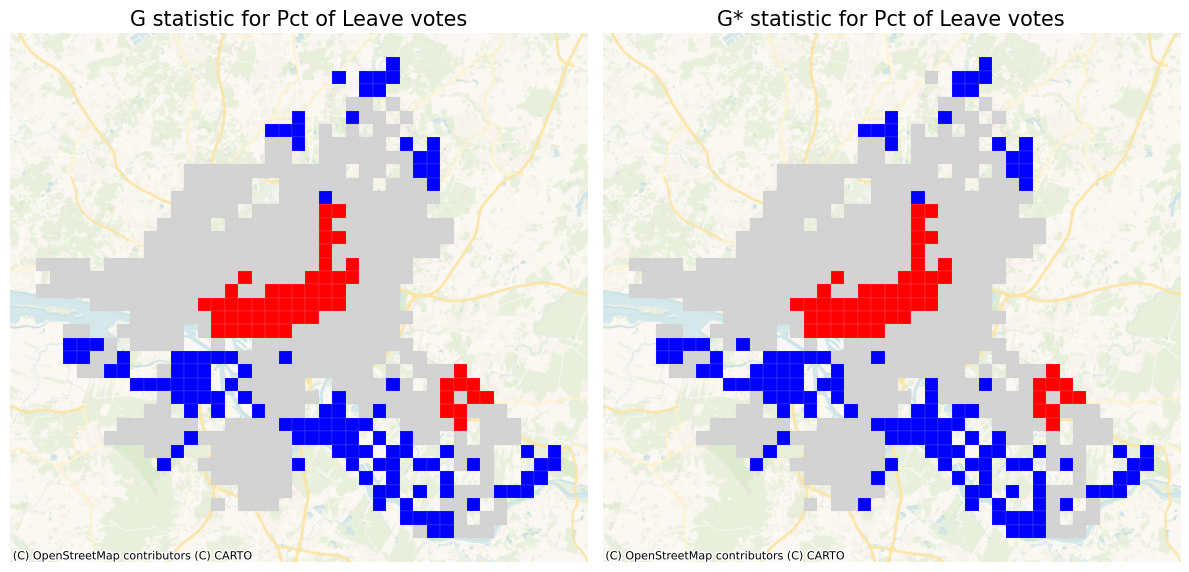

In [23]:
# Set up figure and axes
f, axs = plt.subplots(1, 2, figsize=(12, 6))
# Loop over the two statistics
for g, ax in zip([go_i, go_i_star], axs.flatten()):
    # Generate the statistic's map
    ax = g_map(g, wk_am, ax)
# Tight layout to minimise blank spaces
f.tight_layout()
# Render
plt.show()